In [ ]:
# Visualize prelim_CI_data.xlsx
import pandas as pd
import numpy as np
import altair as alt
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 50)  # Show up to 1000 rows

### Define who the subjects are

In [39]:
subjids = ['deadFish', 'hydrolagusColliei_4', 'hydrolagusColliei_5', 'hydrolagusColliei_6', 'hydrolagusColliei_7', 'hydrolagusColliei_8', 'hydrolagusColliei_9']

### Retrieve Confidence Interval Datasets

In [40]:
# CI dataset
df_CIs = []
for subjid_idx, subjid in enumerate(subjids):
    pattern = f"/home/sphsc/cse583/fish_eeg/analysis/CI_csv/{subjid}/"
    all_files = os.listdir(pattern)
    for file_idx, cur_file in enumerate(all_files):
        tmp = pd.read_csv(os.path.join(pattern, cur_file))
        tmp['subjid'] = subjid
        tmp['test_id'] = cur_file.split('CI_')[1].replace('.csv', '')
        df_CIs.append(tmp)
df_CIs = pd.concat(df_CIs, ignore_index=True)


### Retrieve ICA Weights Dataset

In [ ]:
# ICA weights dataset
df_weights = []
for subjid_idx, subjid in enumerate(subjids):
    pattern = f"/home/sphsc/cse583/fish_eeg/analysis/weights_csv/{subjid}/"
    all_files = os.listdir(pattern)
    for file_idx, cur_file in enumerate(all_files):
        tmp = pd.read_csv(os.path.join(pattern, cur_file))
        tmp['subjid'] = subjid
        tmp['test_id'] = cur_file.split('weights_')[1].replace('.csv', '')
        df_weights.append(tmp)
df_weights = pd.concat(df_weights, ignore_index=True)


## Confidence intervals

### Restructure DataFrame

In [42]:
# Manually recreate the dataframe from the values
data_dict = {
    'Subject_ID': df_CIs['subjid'].tolist(),
    'Test_ID': df_CIs['test_id'].tolist(),
    'Frequency': df_CIs['freq'].tolist(), #.tolist() removes index information, convert to pure python list, 
    'Amplitude': df_CIs['amp'].tolist(),
    'CI_lower': df_CIs['lower_CI'].tolist(),
    'CI_upper': df_CIs['upper_CI'].tolist()
}

# Create midpoint column
df_new = pd.DataFrame(data_dict)
df_new['Midpoint'] = (df_new['CI_lower'] + df_new['CI_upper']) / 2

# Filter out probalamatic data
df_new['group'] = df_new['Subject_ID'] + '_' + df_new['Test_ID'].astype(str)
df_new = df_new[~df_new['Frequency'].isin([50, 385]) & (df_new['Amplitude'] != 145) & (df_new['Amplitude'] != 150)]
df_new = df_new[~((df_new['Subject_ID'] == 'hydrolagusColliei_7') & (df_new['Frequency'].isin([55, 100])))]
df_new = df_new[~((df_new['Subject_ID'] == 'deadFish'))]
df_new

,Subject_ID,Test_ID,Frequency,Amplitude,CI_lower,CI_upper,Midpoint,group
4,hydrolagusColliei_4,0,100,105,-0.138346,0.072922,-0.032712,hydrolagusColliei_4_0
5,hydrolagusColliei_4,0,100,110,-0.200873,0.237800,0.018463,hydrolagusColliei_4_0
6,hydrolagusColliei_4,0,100,115,0.169774,0.846392,0.508083,hydrolagusColliei_4_0
7,hydrolagusColliei_4,0,100,120,0.177111,1.020928,0.599020,hydrolagusColliei_4_0
8,hydrolagusColliei_4,0,100,125,1.004921,2.090262,1.547591,hydrolagusColliei_4_0
...,...,...,...,...,...,...,...,...
194,hydrolagusColliei_9,0,440,140,-0.122621,0.026986,-0.047818,hydrolagusColliei_9_0
197,hydrolagusColliei_9,0,55,110,-0.074493,0.112091,0.018799,hydrolagusColliei_9_0
198,hydrolagusColliei_9,0,55,115,-0.128971,0.094606,-0.017182,hydrolagusColliei_9_0
199,hydrolagusColliei_9,0,55,120,0.256045,0.648667,0.452356,hydrolagusColliei_9_0


### Logistic function

In [ ]:
max_acc = 1.0
def response(x, x0, kappa, lmda, max_response):
    return (lmda / (1 + np.exp(-kappa * (x - x0)))) * max_response # logistic function


### Fit Logistic Function to Data

In [ ]:
# Define Varibles
ci_types = ['CI_lower','CI_upper']
unique_frequencies = np.sort(df_new['Frequency'].unique())
x0_est = 130
max_resp_est = 5
initial_guess = [x0_est, 1.0, 1.0, max_resp_est]

my_subjid = "hydrolagusColliei_4"
my_freq = 100
my_test_id = '0'

logi_dict = {}
for subjid in subjids:
    logi_dict[subjid] = {}
    for freq in unique_frequencies:
        logi_dict[subjid][freq] = {}
        # plt.figure()
        for ci_type in ci_types:
            logi_dict[subjid][freq][ci_type] = {}
            # Get data
            cur_y = df_new.loc[(df_new['Test_ID']==my_test_id) & (df_new['Subject_ID']==subjid) & (df_new['Frequency']==freq), ci_type].values
            cur_x = df_new.loc[(df_new['Test_ID']==my_test_id) & (df_new['Subject_ID']==subjid) & (df_new['Frequency']==freq), 'Amplitude'].values
            
            if len(cur_x) > 0:
               try: 
                    params, covariance = curve_fit(response, cur_x, cur_y, p0=initial_guess)
                    logi_dict[subjid][freq][ci_type] = params
                    # print(f"{ci_type}: {params}")
                    # x_smooth = np.linspace(cur_x.min(), cur_x.max(), 100)
                    # y_fit = response(x_smooth, *params)
                    # color = 'blue' if ci_type == 'CI_lower' else 'orange'
               except RuntimeError:
                   print(f"RuntimeError: {subjid} {freq}")
                   continue
               except TypeError:
                   print(f"TypeError: {subjid} {freq}")
                   continue
        #         plt.scatter(cur_x, cur_y, label=f'{ci_type} Data', color=color)
        #         plt.plot(x_smooth, y_fit, label=f'{ci_type} Fit', color=color)
        # plt.xlim([85,145])
        # plt.ylim([-0.25,5])       
        # plt.xlabel('Amplitude')
        # plt.ylabel('CI')
        # plt.title(f'Subject: {subjid}, Frequency: {freq}')
        # plt.grid(True,alpha=0.5)
        # plt.show()

RuntimeError: hydrolagusColliei_4 55
RuntimeError: hydrolagusColliei_4 330
RuntimeError: hydrolagusColliei_4 330
TypeError: hydrolagusColliei_4 360
TypeError: hydrolagusColliei_4 360
RuntimeError: hydrolagusColliei_5 200
TypeError: hydrolagusColliei_5 300
TypeError: hydrolagusColliei_5 300
TypeError: hydrolagusColliei_5 330
TypeError: hydrolagusColliei_5 330
TypeError: hydrolagusColliei_5 360
TypeError: hydrolagusColliei_5 360
TypeError: hydrolagusColliei_6 55
TypeError: hydrolagusColliei_6 55
RuntimeError: hydrolagusColliei_6 100
TypeError: hydrolagusColliei_6 360
TypeError: hydrolagusColliei_6 360
TypeError: hydrolagusColliei_6 440
TypeError: hydrolagusColliei_6 440
TypeError: hydrolagusColliei_6 880
TypeError: hydrolagusColliei_6 880
TypeError: hydrolagusColliei_8 880
TypeError: hydrolagusColliei_8 880
TypeError: hydrolagusColliei_9 220
TypeError: hydrolagusColliei_9 220
RuntimeError: hydrolagusColliei_9 330
TypeError: hydrolagusColliei_9 360
TypeError: hydrolagusColliei_9 360


/tmp/ipykernel_986/3335802416.py:25: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(response, cur_x, cur_y, p0=initial_guess)
/tmp/ipykernel_986/811535555.py:3: RuntimeWarning: overflow encountered in exp
  return (lmda / (1 + np.exp(-kappa * (x - x0)))) * max_response


### Linearize?

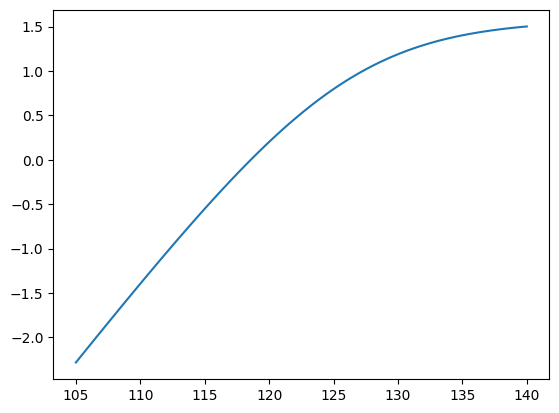

In [187]:
y_log = np.log(response(x_smooth,params[0],params[1],params[2],params[3]))
plt.plot(x_smooth,y_log)


### Gaussian equations

In [284]:
def inverted_gauss(x, H, A, x0, sigma):
    return H - A * np.exp(-(x - x0)**2 / (2 * sigma**2))

In [285]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0)**2 / (2 * sigma**2))

In [289]:
def asym_gauss(x, H, A, x0, sigma_left, sigma_right):
    sigma = np.where(x < x0, sigma_left, sigma_right)
    return H + A * np.exp(-(x - x0)**2 / (2 * sigma**2))

### Parabola equation

In [272]:
def parabola(x, a, b, c):
    return a * (x - b)**2 + c

### Fit gaussian to logistic model parameters

[4.7391421870367045, 0.28269382228864337, 1.7669107019352943, -19.907055877699843]
[55.0, 100.0, 330.0, 440.0]


(-30.0, 10.0)

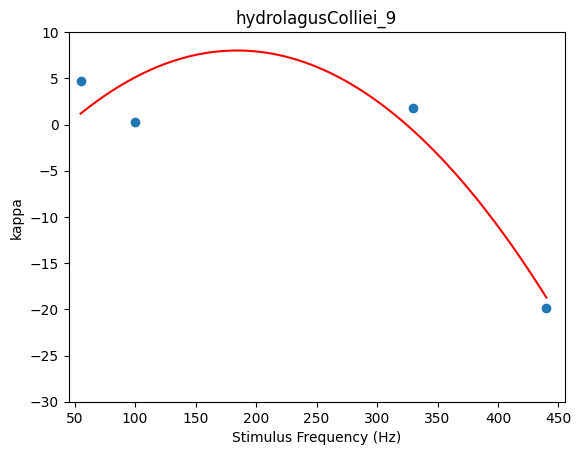

In [299]:
cur_param = 1
cur_param_name = 'kappa'
cur_ci = 'CI_lower'
accum = []
freq_vec = []
my_subjid = "hydrolagusColliei_9"
initial_guess = [1, 1, 0.1]

for freq in unique_frequencies:
    for subjid in [my_subjid]:
        for ci_type in [cur_ci]:
            cur_data = logi_dict[subjid][freq][ci_type]
            if len(cur_data) > 0:
                freq_vec.append(float(freq))
                accum.append(float(logi_dict[subjid][freq][ci_type][cur_param]))

print(accum)
print(freq_vec)
freq_vec = np.array(freq_vec)

params, covariance = curve_fit(parabola, freq_vec, accum, p0=initial_guess)
x_smooth = np.linspace(freq_vec.min(), freq_vec.max(), 100)
y_fit = parabola(x_smooth, *params)

plt.figure()
plt.plot(x_smooth, y_fit, label='Fit', color='red')
plt.scatter(freq_vec,accum)
plt.xlabel('Stimulus Frequency (Hz)')
plt.ylabel(cur_param_name)
plt.title(subjid)
plt.xlim([45,455])
plt.ylim([-30, 10])

### Plot raw data

In [167]:
# Add a zero column to your data
df_new['zero'] = 0

# Create area layer
area = alt.Chart(df_new).mark_area(opacity=0.3).encode(
    x=alt.X('Amplitude:Q', title='Stimulus Amplitude', scale=alt.Scale(domain=[70, 145])),
    y=alt.Y('CI_lower:Q', title='95% Confidence Interval'),
    y2='CI_upper:Q',
    color=alt.Color('Frequency:O',title = 'Frequency (Hz)', scale=alt.Scale(scheme='viridis'), legend=None),
    detail='group:N'  # Add this line
)

# Create y=0 line
zero_line = alt.Chart(df_new).mark_rule(color='black', strokeWidth=.5, strokeDash=[5, 5], opacity=0.3).encode(
    y=alt.datum(0)
)

# Create midpoint line
midpoint_line = alt.Chart(df_new).mark_line(strokeWidth=2).encode(
    x=alt.X('Amplitude:Q', title='Stimulus Amplitude', scale=alt.Scale(domain=[70, 145])),
    y='Midpoint:Q',
    color=alt.Color('Frequency:O', scale=alt.Scale(scheme='viridis'), legend=None),
    detail='group:N'  # Add this line
)

# Create circles
circles = alt.Chart(df_new).mark_circle(size=80).encode(
    x=alt.X('Amplitude:Q', title='Stimulus Amplitude', scale=alt.Scale(domain=[70, 145])),
    y='Midpoint:Q',
    color=alt.Color('Frequency:O', scale=alt.Scale(scheme='viridis'), legend=None),
    tooltip = ['Subject_ID', 'Test_ID','Amplitude','Frequency','CI_lower','CI_upper'],
    detail='group:N'  # Add this line
)

# Layer then facet
chart = (area + zero_line + midpoint_line + circles).properties(
    width=300,
    height=300
).facet(
    facet=alt.Facet('Frequency:N', title='Frequency (Hz)'),
    columns = 4
).properties(
    title='95% CIs by Stimulus Frequency and Amplitude'
).configure_title(
    fontSize=24
).configure_axis(
    labelFontSize=13,
    titleFontSize=14
).configure_header(
    labelFontSize=18,
    titleFontSize=16  
).configure_legend(
    labelFontSize=13,
    titleFontSize=16
).interactive()

chart
chart.save("/home/sphsc/cse583/fish_eeg/analysis/plots/summary_plots/95CI_all.html")
chart.save(
    "/home/sphsc/cse583/fish_eeg/analysis/plots/summary_plots/95CI_all.png",
    engine="vl-convert",
    scale_factor=3  # 3× resolution (higher quality)
)
chart

alt.FacetChart(...)

### Medians

In [168]:
# Calculate median CIs for each stimulus freq and amplitude combination
df_medians = df_new.groupby(['Frequency', 'Amplitude'])[['CI_lower', 'CI_upper', 'Midpoint']].median().reset_index()
df_medians

,Frequency,Amplitude,CI_lower,CI_upper,Midpoint
0,55,90,-0.104638,0.025265,-0.039687
1,55,95,-0.126968,0.063056,-0.031956
2,55,100,-0.094645,0.183082,0.044218
3,55,105,-0.058755,0.199206,0.097060
4,55,110,-0.085112,0.274697,0.064004
...,...,...,...,...,...
69,440,125,-0.034767,0.203216,0.084224
70,440,130,-0.202061,0.088132,-0.056965
71,440,135,-0.204369,0.114366,-0.045002
72,440,140,-0.103331,0.153884,0.012196


In [169]:
# Add a zero column to your data
df_medians['zero'] = 0

# Create area layer
area = alt.Chart(df_medians).mark_area(opacity=0.3).encode(
    x=alt.X('Amplitude:Q', title='Stimulus Amplitude', scale=alt.Scale(domain=[70, 145])),
    y=alt.Y('CI_lower:Q', title='95% Confidence Interval'),
    y2='CI_upper:Q',
    color=alt.Color('Frequency:O',title = 'Frequency (Hz)', scale=alt.Scale(scheme='viridis'), legend=None),
    detail='group:N'  # Add this line
)

# Create y=0 line
zero_line = alt.Chart(df_medians).mark_rule(color='black', strokeWidth=.5, strokeDash=[5, 5], opacity=0.3).encode(
    y=alt.datum(0)
)

# Create midpoint line
midpoint_line = alt.Chart(df_medians).mark_line(strokeWidth=2).encode(
    x=alt.X('Amplitude:Q', title='Stimulus Amplitude', scale=alt.Scale(domain=[70, 145])),
    y='Midpoint:Q',
    color=alt.Color('Frequency:O', scale=alt.Scale(scheme='viridis'), legend=None),
    detail='group:N'  # Add this line
)

# Create circles
circles = alt.Chart(df_medians).mark_circle(size=80).encode(
    x=alt.X('Amplitude:Q', title='Stimulus Amplitude', scale=alt.Scale(domain=[70, 145])),
    y='Midpoint:Q',
    color=alt.Color('Frequency:O', scale=alt.Scale(scheme='viridis'), legend=None),
    tooltip = ['Amplitude','Frequency','CI_lower','CI_upper'],
    detail='group:N'  # Add this line
)

base = (area + zero_line + midpoint_line + circles).properties(
    width=300,
    height=300
)

chart = base.facet(
    facet=alt.Facet('Frequency:N', title='Frequency (Hz)'),
    columns=4
).properties(
    title='Median 95% CIs by Stimulus Frequency and Amplitude'
).configure_title(
    fontSize=24
).configure_axis(
    labelFontSize=13,
    titleFontSize=14
).configure_header(
    labelFontSize=18,
    titleFontSize=16
).configure_legend(
    labelFontSize=13,
    titleFontSize=16
).interactive()

chart

chart.save("/home/sphsc/cse583/fish_eeg/analysis/plots/summary_plots/95CI_median.html")
chart.save(
    "/home/sphsc/cse583/fish_eeg/analysis/plots/summary_plots/95CI_median.png",
    engine="vl-convert",
    scale_factor=3  # 3× resolution (higher quality)
)

chart

alt.FacetChart(...)

## ICA weights

In [170]:
df_weights

,subjid,freq,amp,channel,weight,test_id
0,deadFish,220,130,ch1,0.265048,0
1,deadFish,220,130,ch2,0.292356,0
2,deadFish,220,130,ch3,0.191276,0
3,deadFish,220,130,ch4,0.251320,0
4,deadFish,330,125,ch1,0.192298,0
...,...,...,...,...,...,...
799,hydrolagusColliei_9,55,120,ch4,0.273748,0
800,hydrolagusColliei_9,55,125,ch1,0.228075,0
801,hydrolagusColliei_9,55,125,ch2,0.199321,0
802,hydrolagusColliei_9,55,125,ch3,0.367968,0


In [171]:
# Manually recreate the dataframe from the values
data_dict = {
    'Subject_ID': df_weights['subjid'].tolist(),
    'Test_ID': df_weights['test_id'].tolist(),
    'Frequency': df_weights['freq'].tolist(), #.tolist() removes index information, convert to pure python list, 
    'Amplitude': df_weights['amp'].tolist(),
    'Channel': df_weights['channel'].tolist(),
    'Weight': df_weights['weight'].tolist()
}

# Create midpoint column
df_new = pd.DataFrame(data_dict)

# Filter out probalamatic data
df_new['group'] = df_new['Subject_ID'] + '_' + df_new['Test_ID'].astype(str)
df_new = df_new[~df_new['Frequency'].isin([50, 385]) & (df_new['Amplitude'] != 145) & (df_new['Amplitude'] != 150)]
df_new = df_new[~((df_new['Subject_ID'] == 'hydrolagusColliei_7') & (df_new['Frequency'].isin([55, 100])))]
df_new = df_new[~((df_new['Subject_ID'] == 'deadFish'))]
df_new

,Subject_ID,Test_ID,Frequency,Amplitude,Channel,Weight,group
16,hydrolagusColliei_4,0,100,105,ch1,0.206310,hydrolagusColliei_4_0
17,hydrolagusColliei_4,0,100,105,ch2,0.272643,hydrolagusColliei_4_0
18,hydrolagusColliei_4,0,100,105,ch3,0.267608,hydrolagusColliei_4_0
19,hydrolagusColliei_4,0,100,105,ch4,0.253439,hydrolagusColliei_4_0
20,hydrolagusColliei_4,0,100,110,ch1,0.229503,hydrolagusColliei_4_0
...,...,...,...,...,...,...,...
799,hydrolagusColliei_9,0,55,120,ch4,0.273748,hydrolagusColliei_9_0
800,hydrolagusColliei_9,0,55,125,ch1,0.228075,hydrolagusColliei_9_0
801,hydrolagusColliei_9,0,55,125,ch2,0.199321,hydrolagusColliei_9_0
802,hydrolagusColliei_9,0,55,125,ch3,0.367968,hydrolagusColliei_9_0


In [172]:
# Create circles
circles = alt.Chart(df_new).mark_circle(size=100, opacity=0.5,filled=False).encode(
    x=alt.X('Amplitude:Q', title='Stimulus Amplitude', scale=alt.Scale(domain=[70, 145])),
    y='Weight:Q',
    color=alt.Color('Channel:N'),
    tooltip = ['Subject_ID', 'Test_ID','Amplitude','Frequency','Channel','Weight'],
    detail='group:N'  # Add this line
)

chart = circles.facet(
    facet=alt.Facet('Frequency:N', title='Frequency (Hz)'),
    columns=4
).properties(
    title='ICA weight values'
).configure_title(
    fontSize=24
).configure_axis(
    labelFontSize=13,
    titleFontSize=14
).configure_header(
    labelFontSize=18,
    titleFontSize=16
).configure_legend(
    labelFontSize=13,
    titleFontSize=16
).interactive()

chart
chart.save("/home/sphsc/cse583/fish_eeg/analysis/plots/summary_plots/ICAweights.html")
chart.save(
    "/home/sphsc/cse583/fish_eeg/analysis/plots/summary_plots/ICAweights.png",
    engine="vl-convert",
    scale_factor=3  # 3× resolution (higher quality)
)
chart

alt.FacetChart(...)